# IMDb Sentiment with fastai (Kaggle GPU)

**Goal:** Train a small text classifier on the IMDb dataset using **fastai 2.7.15**, evaluate accuracy, and export a CPU-loadable model file `imdb_sentiment_fastai.pkl`.

**Kaggle Notebook settings**
- Accelerator: **GPU T4 x 2**
- Internet: **On**

**Outputs you’ll download**
- `/kaggle/working/imdb_sentiment_fastai.pkl`  ← exported learner
- `/kaggle/working/metrics.json` (accuracy, loss)
- `/kaggle/working/confusion_matrix.png` (optional viz)

After the run, use the “**Output**” panel (or `File → Download`) to grab the files.

In [1]:
# # Align the stack for fastai 2.7.x text (NumPy 1.x, Pillow<12, etc.)
# !pip -q install -U "numpy<2" "matplotlib<3.9" "pillow<12" "typing_extensions>=4.13" \
#                      fastai==2.7.15 spacy==3.8.7

# # Hard-restart the Python process so the new wheels are actually used
# import os, sys
# os.kill(os.getpid(), 9)

In [2]:
# Stdlib
import os, json, re, time, platform, random
from pathlib import Path

# Scientific / plotting
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# PyTorch / fastai
import torch
import fastai
from fastai.text.all import *
from fastai.interpret import ClassificationInterpretation
from fastai.callback.schedule import minimum, steep

# Sanity checks
print("NumPy:", np.__version__)            # should be 1.26.x
print("Matplotlib:", matplotlib.__version__) # should be <3.9
print("Python:", platform.python_version())
print("fastai:", fastai.__version__)
print("PyTorch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

NumPy: 1.26.4
Matplotlib: 3.7.2
Python: 3.11.13
fastai: 2.8.4
PyTorch: 2.6.0+cu124 | CUDA available: True
GPU: Tesla T4


In [3]:
# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

In [4]:
# Fastai will download and cache IMDB under /root/.fastai
path = untar_data(URLs.IMDB)
path.ls()[:5], (path/'train').ls()[:5]

((#5) [Path('/root/.fastai/data/imdb/imdb.vocab'),Path('/root/.fastai/data/imdb/README'),Path('/root/.fastai/data/imdb/unsup'),Path('/root/.fastai/data/imdb/test'),Path('/root/.fastai/data/imdb/tmp_lm')],
 (#4) [Path('/root/.fastai/data/imdb/train/neg'),Path('/root/.fastai/data/imdb/train/unsupBow.feat'),Path('/root/.fastai/data/imdb/train/labeledBow.feat'),Path('/root/.fastai/data/imdb/train/pos')])

In [5]:
# --- TRAIN dataloaders (use this for training; keep specials) ---
# path should already be defined earlier; e.g.:
# path = Path('/kaggle/input/imdb')  # or wherever your train/test folders live

dls = TextDataLoaders.from_folder(
    path, valid='test', bs=64, seq_len=72, is_lm=False
)

# quick sanity check
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxmaj some have praised _ xxunk _ as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n\n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff "" of many older adventure movies has been done well before , ( think _ the xxmaj dirty xxmaj dozen _ ) but _ atlantis _ represents one of the worse films in that motif . xxmaj the characters are weak . xxmaj even the background that each member trots out seems stock and awkward at best . xxmaj an xxup md / xxmaj medicine xxmaj man , a tomboy mechanic whose father always wanted sons , if we have not at least seen these before",neg
2,"xxbos xxmaj warning : xxmaj does contain spoilers . \n\n xxmaj open xxmaj your xxmaj eyes \n\n xxmaj if you have not seen this film and plan on doing so , just stop reading here and take my word for it . xxmaj you have to see this film . i have seen it four times so far and i still have n't made up my mind as to what exactly happened in the film . xxmaj that is all i am going to say because if you have not seen this film , then stop reading right now . \n\n xxmaj if you are still reading then i am going to pose some questions to you and maybe if anyone has any answers you can email me and let me know what you think . \n\n i remember my xxmaj grade 11 xxmaj english teacher quite well . xxmaj",pos


In [6]:
# --- Pretty-print detokenized fastai text for human preview only ---
def prettify_fastai(s: str,
                    drop_unknown: bool = False,
                    unk_token: str = "[UNK]") -> str:
    # expand "xxrep 3 x" -> "xxx"
    s = re.sub(r'xxrep\s+(\d+)\s+(\S)', lambda m: m.group(2) * int(m.group(1)), s)
    # expand "xxwrep 4 hi" -> "hihihihi"
    s = re.sub(r'xxwrep\s+(\d+)\s+(\S+)', lambda m: m.group(2) * int(m.group(1)), s)

    # convert line break marker
    s = s.replace('xxbr', '\n')

    # remove markers that only carry casing/structure info
    for t in ('xxbos', 'xxmaj', 'xxup'):
        s = s.replace(t, '')

    # hide or replace unknowns
    if drop_unknown:
        s = re.sub(r'\bxxunk\b', '', s)
    else:
        s = re.sub(r'\bxxunk\b', unk_token, s)

    # tidy repeated spaces and pad punctuation
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'\s+([,.!?;:])', r'\1', s)
    return s.strip()

In [7]:
# --- Clean preview for a few rows from the current dataloader ---
def show_clean_batch(dls, n=3, drop_unknown=False):
    xb, yb = dls.one_batch()
    decoded = dls.decode_batch((xb, yb))   # list of rows; each row may include extras

    for i, row in enumerate(decoded[:n]):
        # row[0] can be a str or a tuple/list with the text at [0]
        text = row[0] if isinstance(row[0], str) else row[0][0]
        # label can be Category, int, or str
        lab  = row[1]
        lab  = lab if isinstance(lab, str) else (lab.item() if hasattr(lab, "item") else str(lab))
        print(f"[{i}] {lab}:\n{prettify_fastai(text, drop_unknown=drop_unknown)}\n")

# Try it
show_clean_batch(dls, n=3, drop_unknown=True)   # hide xxunk (set False to show [UNK])

[0] pos:
match 1: tag team table match bubba ray and spike dudley vs eddie guerrero and chris benoit bubba ray and spike dudley started things off with a tag team table match against eddie guerrero and chris benoit. according to the rules of the match, both opponents have to go through tables in order to get the win. benoit and guerrero heated up early on by taking turns hammering first spike and then bubba ray. a german by benoit to bubba took the wind out of the dudley brother. spike tried to help his brother, but the referee restrained him while benoit and guerrero up on him in the corner. with benoit stomping away on bubba, guerrero set up a table outside. spike dashed into the ring and over the top rope onto guerrero on the outside! after recovering and taking care of spike, guerrero slipped a table into the ring and helped the wolverine set it up. the tandem then set up for a double from the middle rope which would have put bubba through the table, but spike knocked the table ove

In [8]:
%%time

learn = text_classifier_learner(
    dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy
)

# Mixed precision can speed up on GPU a bit
if torch.cuda.is_available():
    learn = learn.to_fp16()
learn

CPU times: user 3.32 s, sys: 1.04 s, total: 4.36 s
Wall time: 4.71 s


### What the Learning Rate Finder does (and why use it)

The **LR finder** runs a very short training pass where it **exponentially increases the learning rate** from tiny to large while recording the loss. From this curve it suggests two points:

- **`minimum`** — LR where the loss is lowest (a safe, conservative choice).
- **`steep`** — LR just **before** the loss shoots up (a faster choice that often works well).

#### Why it helps
- Picks a **sensible LR automatically**, avoiding guesswork.
- Yields **faster convergence** and **better stability** (avoids too-small “slow” LRs and too-large “explode” LRs).
- Plays nicely with fastai’s **one-cycle** schedule, which expects a reasonable `base_lr`.

#### When to skip
- If you’re in a rush or the dataset is tiny, you can skip the finder and use a known-good default (e.g., `2e-3`), then adjust if training diverges or is too slow.

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


LR suggestions  ->  min: 0.06309573650360108  | steep: 0.0020892962347716093


/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,0.460694,0.387179,0.822400,01:07


/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,0.366046,0.298494,0.873840,02:17
1,0.313300,0.260681,0.892400,02:16
2,0.290244,0.251462,0.897960,02:17
3,0.255249,0.229605,0.907800,02:16
4,0.235668,0.225859,0.908840,02:17
5,0.212947,0.208193,0.918520,02:17
6,0.199558,0.203461,0.919600,02:16
7,0.183208,0.208015,0.920600,02:17
8,0.166599,0.209136,0.921320,02:16
9,0.172480,0.210689,0.916520,02:17


Training took 1437.4s
CPU times: user 21min 47s, sys: 2min 13s, total: 24min 1s
Wall time: 24min 8s


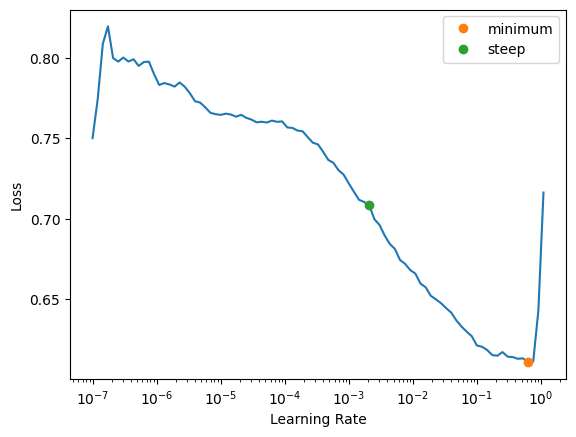

In [9]:
%%time

# OPTIONAL: learning rate finder + timed fine_tune
# run lr_find quietly (optional)
with learn.no_logging():
    lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

print("LR suggestions  ->  min:", lr_min, " | steep:", lr_steep)

# choose one (fall back if None)
chosen_lr = float(lr_steep) if lr_steep is not None else 2e-3

start = time.time()
learn.fine_tune(10, base_lr=chosen_lr)   # bump epochs for better accuracy later
print(f"Training took {time.time() - start:.1f}s")

In [10]:
%%time

# Recompute validation metrics (floats)
res = learn.validate()                 # -> [loss, acc, ...]
val_loss, val_acc = float(res[0]), float(res[1])

# Try to infer how many epochs actually ran
epochs = None
try:
    # recorder.values is a list of [train_loss, valid_loss, metric, ...] per epoch
    epochs = len(learn.recorder.values)
except Exception:
    try:
        # fallback: estimate from number of training batches logged
        epochs = len(learn.recorder.losses) // len(learn.dls.train)
    except Exception:
        epochs = None

metrics = {
    "loss": round(val_loss, 6),
    "accuracy": round(val_acc, 6),
    "epochs": epochs,
    "fastai": fastai.__version__,
    "torch": torch.__version__,
}

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


CPU times: user 32.3 s, sys: 439 ms, total: 32.8 s
Wall time: 33.5 s


In [11]:
samples = [
    "This movie was absolutely wonderful with brilliant performances.",
    "Terrible plot, wooden acting. I want my time back.",
    "Not bad at all—some pacing issues, but I enjoyed it overall."
]
for s in samples:
    label,_, probs = learn.predict(s)
    print(f"\nText: {s}\n → Pred: {label}  (neg={probs[0]:.3f}, pos={probs[1]:.3f})")

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()



Text: This movie was absolutely wonderful with brilliant performances.
 → Pred: pos  (neg=0.005, pos=0.995)


/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()



Text: Terrible plot, wooden acting. I want my time back.
 → Pred: neg  (neg=0.994, pos=0.006)


/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()



Text: Not bad at all—some pacing issues, but I enjoyed it overall.
 → Pred: pos  (neg=0.058, pos=0.942)


In [12]:
# Ensure WORK exists (Kaggle/Colab-safe)
WORK = Path(globals().get("WORK", "/kaggle/working"))
WORK.mkdir(parents=True, exist_ok=True)

In [13]:
# Export model
export_path = WORK/"imdb_sentiment_fastai.pkl"
learn.export(export_path)
print("Exported model to:", export_path)
!ls -lh /kaggle/working | sed -n '1,20p'

Exported model to: /kaggle/working/imdb_sentiment_fastai.pkl
total 221M
-rw-r--r-- 1 root root 221M Oct 21 14:01 imdb_sentiment_fastai.pkl


In [14]:
# Save metrics
with open(WORK/"metrics.json","w") as f:
    json.dump(metrics, f, indent=2)
print("Wrote:", WORK/"metrics.json")
!ls -lh /kaggle/working | sed -n '1,20p'

Wrote: /kaggle/working/metrics.json
total 221M
-rw-r--r-- 1 root root 221M Oct 21 14:01 imdb_sentiment_fastai.pkl
-rw-r--r-- 1 root root  107 Oct 21 14:01 metrics.json
